In [1]:
# Copyright (c) Facebook, Inc. and its affiliates.
import contextlib
import io
import logging
import os
from collections import defaultdict
from dataclasses import dataclass
from typing import Any, Dict, Iterable, List, Optional
from fvcore.common.timer import Timer
from PIL import Image
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.file_io import PathManager
import numpy as np
from pathlib import Path
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from densepose.data.utils import maybe_prepend_base_path
from densepose import add_densepose_config
from densepose.structures import DensePoseChartPredictorOutput, DensePoseEmbeddingPredictorOutput
from densepose.utils.logger import verbosity_to_level
from densepose.vis.base import CompoundVisualizer
from densepose.vis.bounding_box import ScoredBoundingBoxVisualizer
from densepose.vis.densepose_outputs_vertex import (
    DensePoseOutputsTextureVisualizer,
    DensePoseOutputsVertexVisualizer,
    get_texture_atlases,
)
from densepose.vis.densepose_results import (
    DensePoseResultsContourVisualizer,
    DensePoseResultsFineSegmentationVisualizer,
    DensePoseResultsUVisualizer,
    DensePoseResultsVVisualizer,
)
from densepose.vis.densepose_results_textures import (
    DensePoseResultsVisualizerWithTexture,
    get_texture_atlas,
)
from densepose.vis.extractor import (
    CompoundExtractor,
    DensePoseOutputsExtractor,
    DensePoseResultExtractor,
    create_extractor,
)

setup_logger()

In [ ]:
import sys
sys.path.append('/mnt/data/repos/dashtoon-research/ClothesPreprocessor')

In [ ]:
from src import data, layers, modelling

In [9]:
dataset_dicts = DatasetCatalog.get("my_densepose_coco_2014_train_cse") #my_densepose_minival2014_cse,my_densepose_valminusminival2014_cse
for d in dataset_dicts:
    fn = d["file_name"]
    # write file_name to text file
    with open("/mnt/data/repos/dashtoon-research/ClothesPreprocessor/datasets/coco/annotations/test.lst", "a") as myfile:
        myfile.write(fn + "\n")

In [4]:
dataset_dicts = DatasetCatalog.get("my_densepose_valminusminival2014_cse")
metadata = MetadataCatalog.get("my_densepose_valminusminival2014_cse")

In [5]:
for d in dataset_dicts:
    try:
        image = Image.open(d['file_name'])
        image = np.array(image)
        image_vis = Visualizer(image, metadata=metadata)
        out = image_vis.draw_dataset_dict(d)
        break
    except Exception as e:
        continue

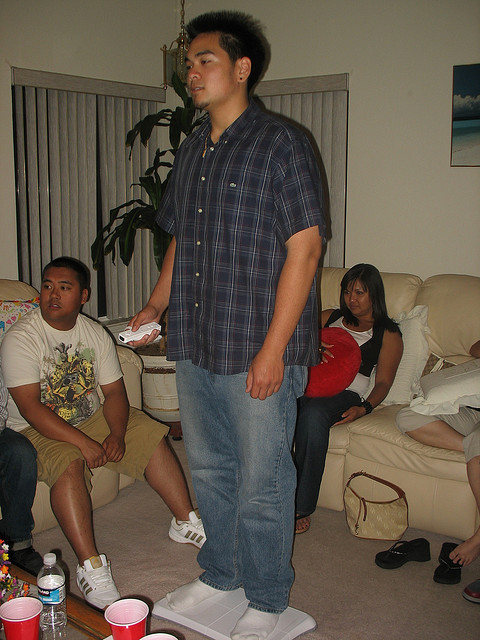

In [6]:
Image.fromarray(image)

ValueError: Could not save to JPEG for display

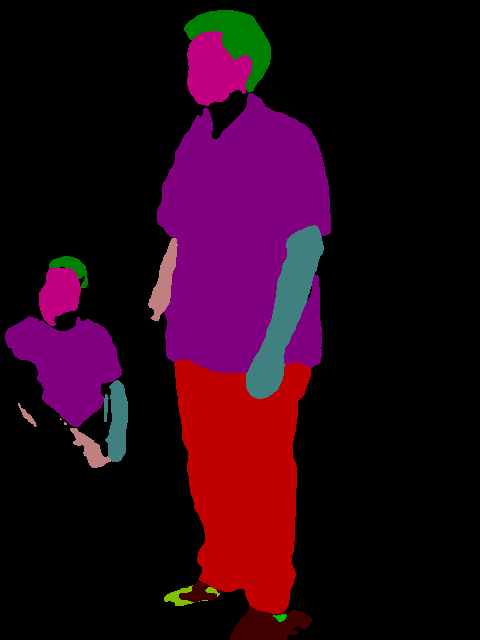

In [10]:
sem_seg = Image.open(d['sem_seg_file_name'])
sem_seg

In [11]:
print(np.unique(sem_seg))

[ 0  2  5  8  9 13 14 15 18 19]


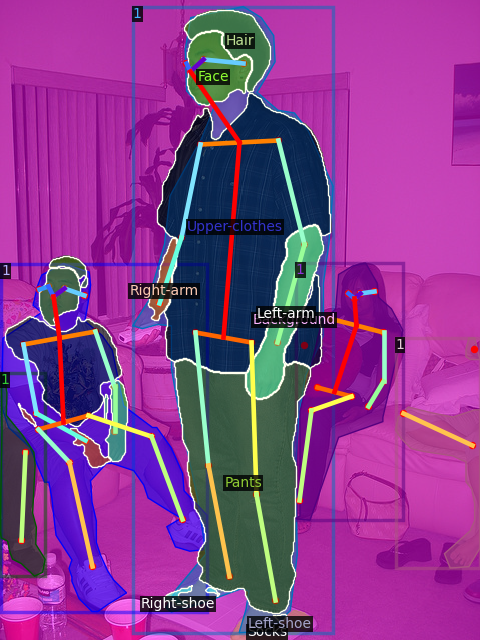

In [8]:
Image.fromarray(out.get_image())

In [1]:
import torch

In [2]:
res = torch.load('/mnt/data/repos/dashtoon-research/ClothesPreprocessor/third_party/VITON-PRE-PROCESSING/Human-Parsing/mhp_extension/detectron2_prediction/inference/instances_predictions.pth')

In [4]:
type(res[0])

dict

In [5]:
res[0].keys()

dict_keys(['image_id', 'instances'])

In [6]:
res[0]

{'image_id': 42, 'instances': []}

In [7]:
res[1]

{'image_id': 73, 'instances': []}

In [10]:
# get prediction via image id could be any row
pred = [x for x in res if x['image_id'] == 391895][0]

In [11]:
pred

{'image_id': 391895,
 'instances': [{'image_id': 391895,
   'category_id': 0,
   'bbox': [348.6664123535156,
    21.747905731201172,
    146.51351928710938,
    301.9300537109375],
   'score': 0.9997167587280273,
   'segmentation': {'size': [360, 640],
    'counts': '[Yk35R;2M3nLMlJ4d3^1QK]NC8T5d1PK^NF1V5f1QK\\NF0V5g1RK]NDNV5i1SK_N@LW4[OYL_2LDi3PNWL_2MDk3oMVL^2NDk3PNUL\\2OFj3PNUL[21Fh3RNTLW23Kf3QNSLU27Md3PNSLS29Oc3PNQLR2=Mc3SNlKP2b0Mb3m0aLRO`3j0dL[NV4d1kK[NW4d1jKZNV4i1iKUNV4o1hKPNX4T2bKmM`4V2[K`LGj0n4n2QKZL4e0l4e3UKXLl4h3XKRLj4n3ZKlKh4T4[KdKj4]4WK^Kl4b4VKYKm4g4j0000000O1N2N2H8K5N2O1N2O1O1N4M3M4L3M2N2O2N?A9G2M3N001O001O0000000000000000000000001N101O002N2N2N100O00001O01O0010001001O00WIPNX4o1dKVN]4i1\\K`NQ5R1UJLk51nI6P6MjI7V6GhI=X6gNTIOc0\\1U7bNjHb1T7]NjHh1S7WNmHk1R7TNnHm1W7lMiHU2[7fMfH[2S8000011O3O1O0N010O3N92F4K2M1022O0M000N3M4M8Ga0_O5K5K5K5K2N1O1N101O2N1O4J8H]eb1'}}]}